In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Descriptions

Filter model predictions by rolling std and compare performance metrics.

# Imports

In [89]:
import datetime
import logging

import dataflow_orange.system.Cx as dtfosc
import matplotlib.pyplot as plt
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdataframe as hdatafr
import helpers.hdataframe as hdatafr
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hpandas as hpandas
import helpers.hprint as hprint

In [90]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='master'
  hash='699819c0c'
  # Last commits:
    * 699819c0c Vlad     CmTask3855_Setup_OKX_bidask_realtime_websocket_download_via_CCXT (#3875) (  13 hours ago) Wed Mar 1 18:59:05 2023  (HEAD -> master, origin/master, origin/HEAD)
    * 922e89415 Toma Jordania Cm task3798 tokens follow up (#3963)                              (  17 hours ago) Wed Mar 1 14:35:42 2023           
    * c2a6f2fff Daniil Tikhomirov CMTask3194: Log child orders (#3958)                              (  21 hours ago) Wed Mar 1 10:57:48 2023           
# Machine info
  system=Linux
  node name=38f5f2a60463


# Config

In [91]:
config = {
    "dir_name": "/shared_data/model/historical/build_tile_configs.C1c.ccxt_v7_1-all.5T.2019-10-01_2023-02-13.ins/tiled_results/",
    "asset_id_col": "asset_id",
    "dag_builder_name": "C1c",
    "start_date": datetime.date(2019, 10, 1),
    "end_date": datetime.date(2023, 2, 13),
    "plot_portfolio_stats_freq": "D",
    "fep_annotate_forecasts_kwargs": {
        "quantization": "no_quantization",
        "burn_in_bars": 3,
        "style": "longitudinal",
        "liquidate_at_end_of_day": False,
        "initialize_beginning_of_day_trades_to_zero": False,
    },
    "fep_binning_portfolio": {
        "proportion_of_data_per_bin": 0.5,
    },
    "rolling_std_dev_factor": 0.5,
}
# Add `DagBuilder` column names to the config.
system_config = dtfosc.get_Cx_system_config_template_instance(
    config["dag_builder_name"]
)
dag_builder = system_config["dag_builder_object"]
column_tags = ["price", "volatility", "prediction"]
config["column_names"] = dag_builder.get_column_names_dict(column_tags)
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C1c.ccxt_v7_1-all.5T.2019-10-01_2023-02-13.ins/tiled_results/
asset_id_col: asset_id
dag_builder_name: C1c
start_date: 2019-10-01
end_date: 2023-02-13
plot_portfolio_stats_freq: D
fep_annotate_forecasts_kwargs: 
  quantization: no_quantization
  burn_in_bars: 3
  style: longitudinal
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
fep_binning_portfolio: 
  proportion_of_data_per_bin: 0.5
rolling_std_dev_factor: 0.5
column_names: 
  price: vwap
  volatility: close.ret_0.vol
  prediction: close.ret_0.vol_adj.shift_-1_hat


# Load results

## Load actual data

In [92]:
data_cols = list(config["column_names"].to_dict().values())
iter_ = dtfmod.yield_processed_parquet_tiles_by_year(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    data_cols,
    asset_ids=None,
)
df_res = hpandas.get_df_from_iterator(iter_)
df_res.head()

  0%|          | 0/5 [00:00<?, ?it/s]

close.ret_0.vol            close.ret_0.vol_adj.shift_-1_hat                  vwap              close.ret_0.vol                                                                                                                                                                                                                                                   close.ret_0.vol_adj.shift_-1_hat                                                                                                                                                                                                                                                         vwap                                                                                                                                                                                                                                                  
asset_id                       1464553467 1467591036                       1464553467 1467591036 1464553467   1467591036      1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                       1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2019-10-01 00:00:00+00:00             NaN   0.001272                              NaN  -0.047946        NaN  8282.824049             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                              NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2019-10-01 00:05:00+00:00             NaN   0.003567                              NaN  -0.009480        NaN  8245.537329             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    

## Filter data by rolling std

In [93]:
# TODO(@gp): Decide on the rolling window size.
window = int(pd.Timedelta("4D") / pd.Timedelta("5T"))
window

1152

In [94]:
prediction_var = config["column_names"]["prediction"]
# Compute rolling mean.
prediction_rolling_mean = (
    df_res[prediction_var]
    .rolling(window)
    .mean()
    .rename(columns={prediction_var: "prediction_rolling_mean"})
)
# Compute rolling std.
prediction_rolling_std = (
    df_res[prediction_var]
    .rolling(window)
    .std()
    .rename(columns={prediction_var: "prediction_rolling_std"})
)
# Set filter condition.
filter_cond = (df_res[prediction_var] - prediction_rolling_mean).abs() > config[
    "rolling_std_dev_factor"
] * prediction_rolling_std
# Create a copy of data with filtered predictions.
df_res_filtered = df_res.copy()
# Replace predictions that do not pass condition with `None`.
df_res_filtered[prediction_var] = df_res_filtered[prediction_var][filter_cond]
df_res_filtered.tail()

close.ret_0.vol            close.ret_0.vol_adj.shift_-1_hat                    vwap               close.ret_0.vol                                                                                                                                                                                                                                                   close.ret_0.vol_adj.shift_-1_hat                                                                                                                                                                                                                                                         vwap                                                                                                                                                                                                                                                   
asset_id                       1464553467 1467591036                       1464553467 1467591036   1464553467    1467591036      1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                       1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2023-02-06 23:40:00+00:00        0.002375   0.001859                        -0.012216  -0.023428  1613.498840  22742.975939        0.004048   0.003940   0.004518   0.002868   0.002801   0.004256   0.003739   0.005004   0.005215   0.004602   0.003833   0.003493   0.003286   0.003319   0.003003   0.005872   0.003364   0.002866   0.002132   0.002978   0.003212   0.001329   0.003767                              NaN        NaN        NaN        NaN        NaN        NaN        NaN  -0.016074        NaN        NaN        NaN        NaN  -0.014004        NaN        NaN        NaN        NaN        NaN        NaN  -0.016583        NaN  -0.014798        NaN   0.504277   0.233966   5.537371   6.469884   0.530137   1.770239  22.696149   2.652779   0.427219   1.045085   0.129354  10.632228   6.810909   1.190499   0.089290   2.876433   0.705269   0.828967   0.392375   5.589025  19.604372  325.160426   2.303191
2023-02-06 23:45:00+00:00        0.002053   0.001559                              NaN  -0.016215  1614.513246  22743.484238        0.002890   0.002546   0.003989   0.003271   0.002630   0.003005   0.003088   0.004004   0.004496   0.004963   0.002748   0.003191   0.002933   0.002915   0.002572   0.005931   0.002824   0.003268   0.002108   0.002684   0.002560   0.001362   0.003273 

# Compare research PnL

In [95]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    config["column_names"]["price"],
    config["column_names"]["volatility"],
    config["column_names"]["prediction"],
)

In [96]:
portfolio_df, bar_metrics = fep.annotate_forecasts(
    df_res,
    # bulk_frac_to_remove=config["fep_annotate_forecasts_kwargs"]["bulk_frac_to_remove"],
    # bulk_fill_method=config["fep_annotate_forecasts_kwargs"]["bulk_fill_method"],
    # target_gmv=config["fep_annotate_forecasts_kwargs"]["target_gmv"],
    quantization=config["fep_annotate_forecasts_kwargs"]["quantization"],
    burn_in_bars=config["fep_annotate_forecasts_kwargs"]["burn_in_bars"],
    style=config["fep_annotate_forecasts_kwargs"]["style"],
    liquidate_at_end_of_day=config["fep_annotate_forecasts_kwargs"][
        "liquidate_at_end_of_day"
    ],
    initialize_beginning_of_day_trades_to_zero=config[
        "fep_annotate_forecasts_kwargs"
    ]["initialize_beginning_of_day_trades_to_zero"],
)

INFO  spread is `None`; imputing spread_lower_bound=0.000100


In [97]:
portfolio_df_filtered, bar_metrics_filtered = fep.annotate_forecasts(
    df_res_filtered,
    # bulk_frac_to_remove=config["fep_annotate_forecasts_kwargs"]["bulk_frac_to_remove"],
    # bulk_fill_method=config["fep_annotate_forecasts_kwargs"]["bulk_fill_method"],
    # target_gmv=config["fep_annotate_forecasts_kwargs"]["target_gmv"],
    quantization=config["fep_annotate_forecasts_kwargs"]["quantization"],
    burn_in_bars=config["fep_annotate_forecasts_kwargs"]["burn_in_bars"],
    style=config["fep_annotate_forecasts_kwargs"]["style"],
    liquidate_at_end_of_day=config["fep_annotate_forecasts_kwargs"][
        "liquidate_at_end_of_day"
    ],
    initialize_beginning_of_day_trades_to_zero=config[
        "fep_annotate_forecasts_kwargs"
    ]["initialize_beginning_of_day_trades_to_zero"],
)

INFO  spread is `None`; imputing spread_lower_bound=0.000100


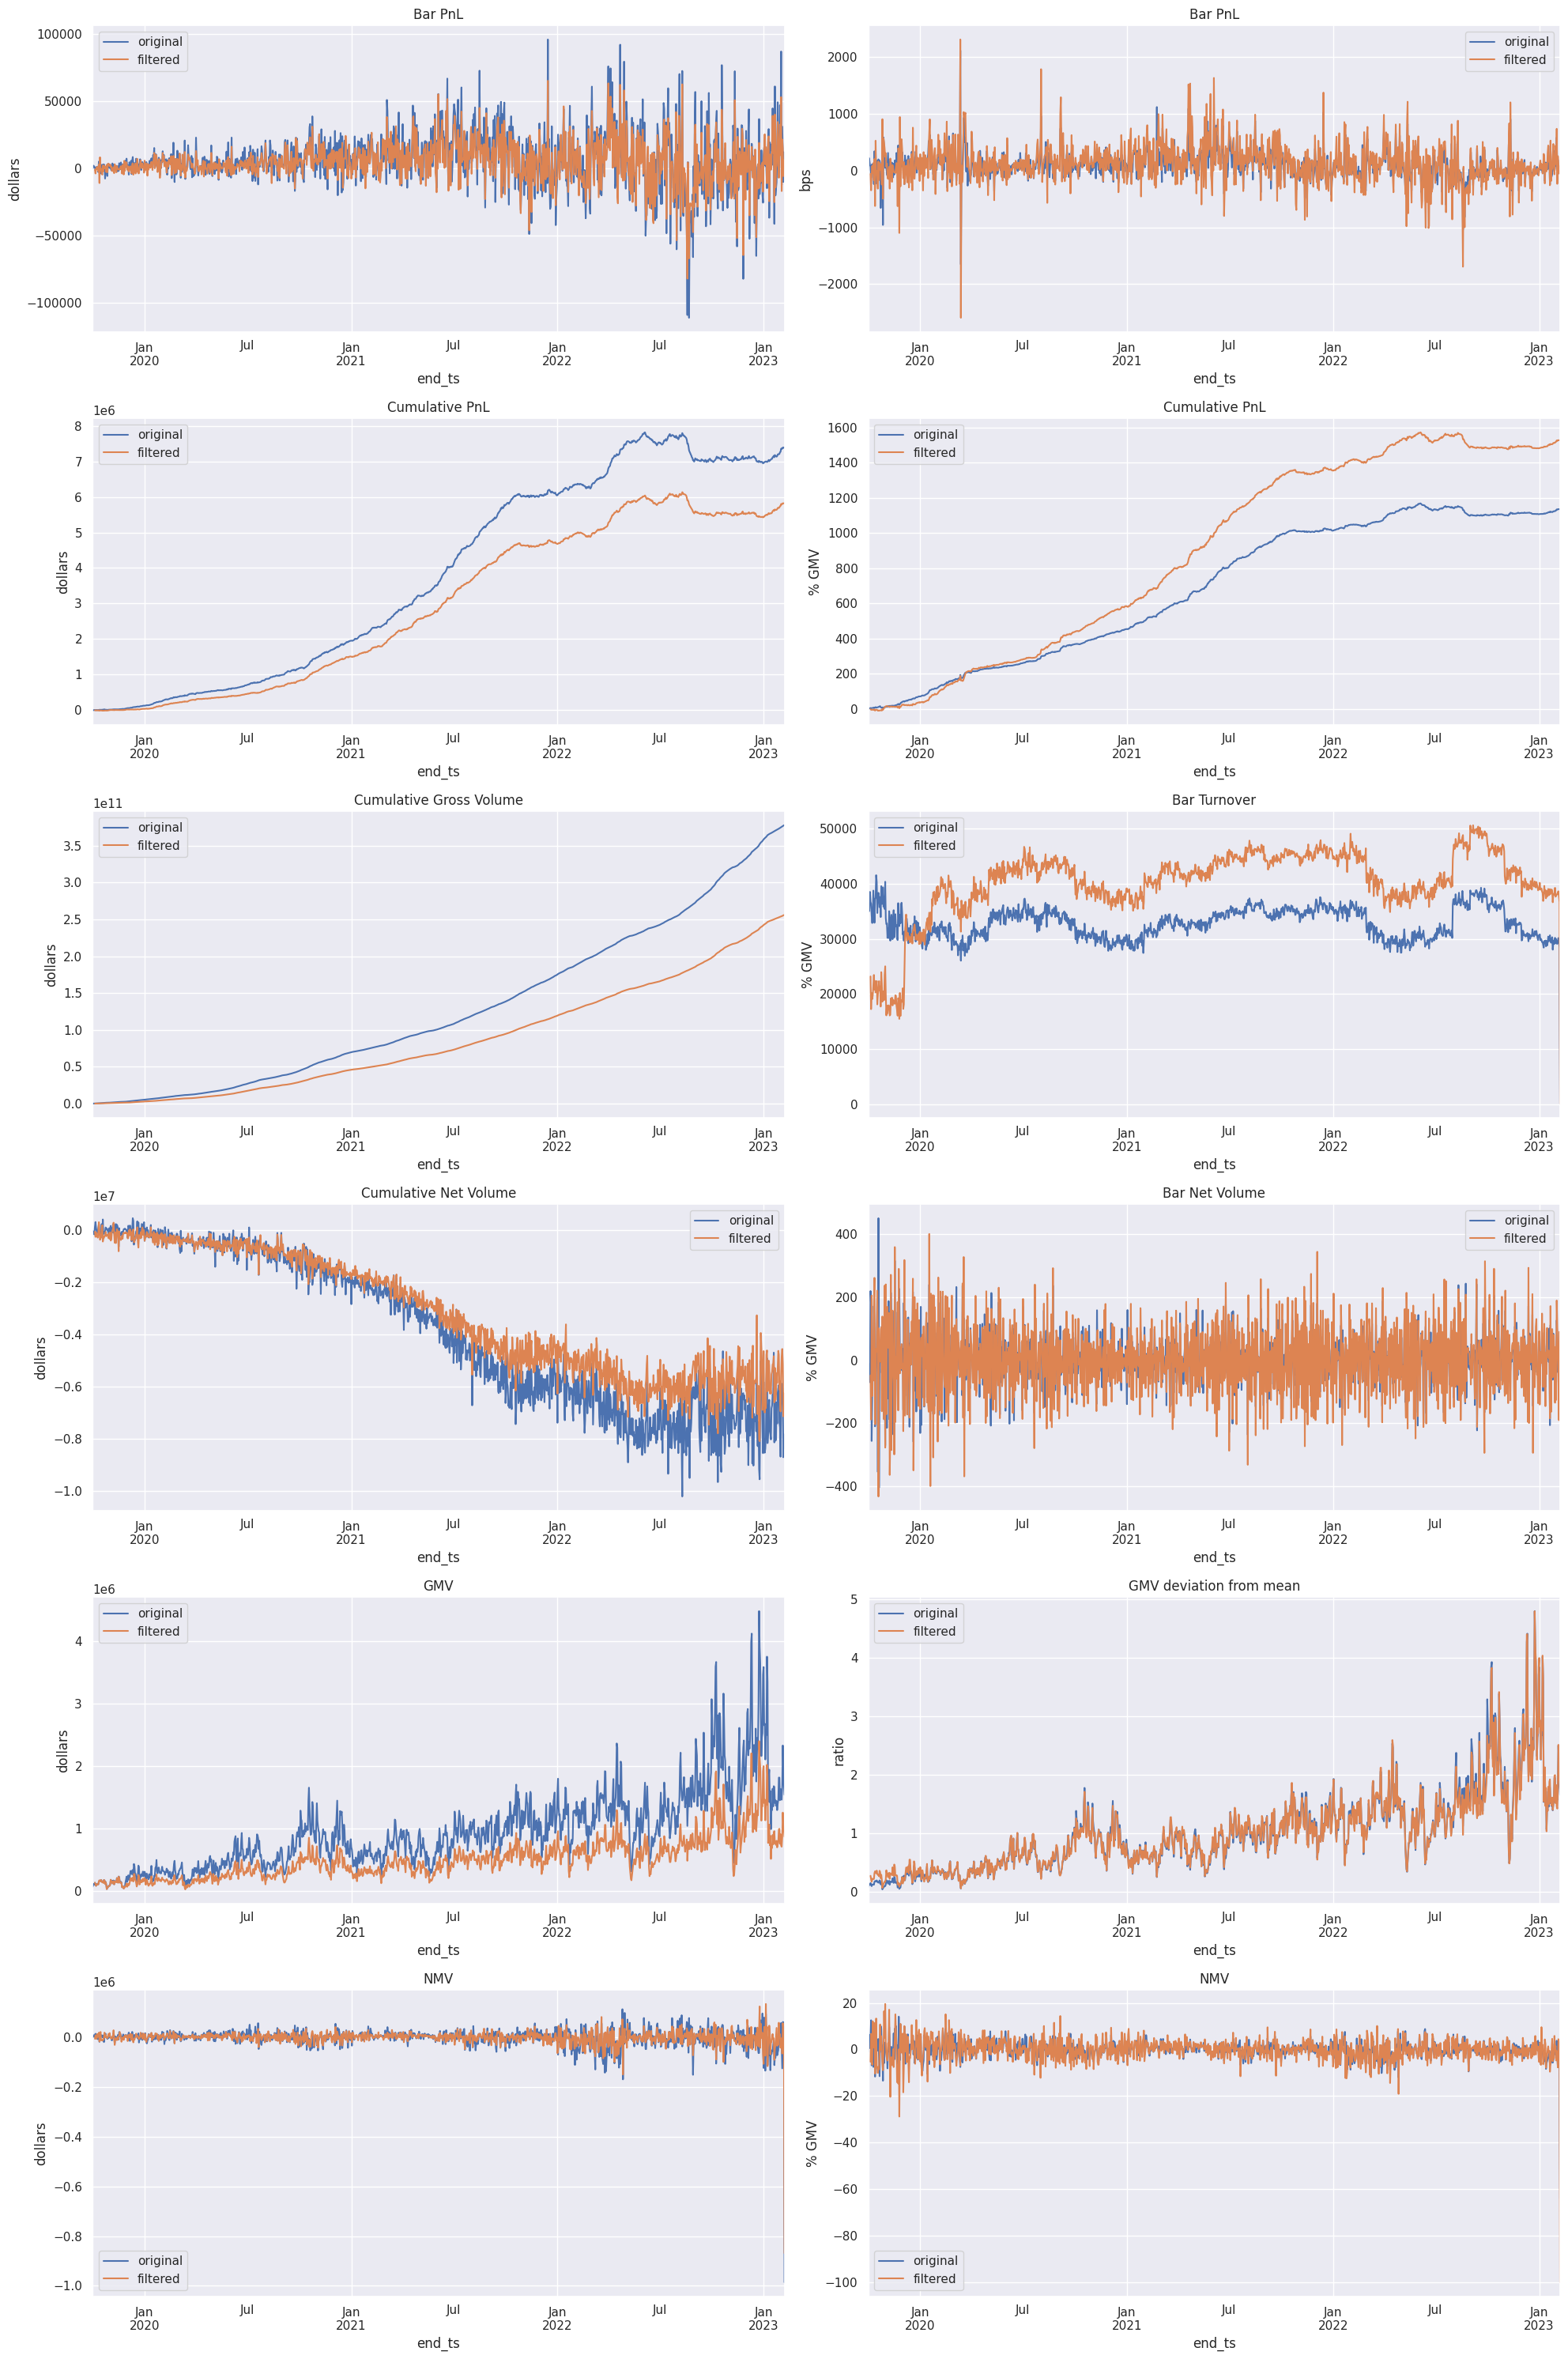

In [98]:
all_metrics_dict = {
    "original": bar_metrics,
    "filtered": bar_metrics_filtered,
}
all_bar_metrics = pd.concat(
    all_metrics_dict.values(), axis=1, keys=all_metrics_dict.keys()
)
#
coplotti.plot_portfolio_stats(
    all_bar_metrics,
    freq=config["plot_portfolio_stats_freq"],
)

# Compare stats

In [99]:
stats_computer = dtfmod.StatsComputer()

In [100]:
portfolio_stats, _ = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["plot_portfolio_stats_freq"],
)
portfolio_stats_filtered, _ = stats_computer.compute_portfolio_stats(
    bar_metrics_filtered,
    config["plot_portfolio_stats_freq"],
)
#
all_portfolio_stats = pd.concat(
    [portfolio_stats, portfolio_stats_filtered],
    axis=1,
    keys=["original", "filtered"],
)
with pd.option_context("display.float_format", "{:,.2f}".format):
    display(all_portfolio_stats)

original       filtered
ratios     sharpe_ratio                          5.71           5.98
           sharpe_ratio_standard_error           0.56           0.56
           sr.tval                              10.46          10.94
           sr.pval                               0.00           0.00
           kratio                                2.20           2.25
dollar     gmv_mean                        933,996.81     500,419.70
           gmv_stdev                       630,406.36     325,339.04
           annualized_mean_return        2,201,022.67   1,739,825.30
           annualized_volatility           385,506.41     290,837.29
           max_drawdown                    871,346.96     708,054.20
           pnl_mean                          6,026.07       4,763.38
           pnl_std                          20,171.42      15,217.91
           turnover_mean               307,951,583.11 209,314,792.90
           turnover_stdev              211,264,981.14 142,070,916.21
           market_bias_mean                 -3,535.36      -2,576.99
           market_bias_stdev                41,125.04      33,194.38
percentage annualized_mean_return              235.66         347.67
           annualized_volatility                41.27          58.12
           max_drawdown                         93.29         141.49
           pnl_mean                              0.65           0.95
           pnl_std                               2.16           3.04
           turnover_mean                    32,971.37      41,827.85
           turnover_stdev                   22,619.45      28,390.35
           market_bias_mean                     -0.38          -0.51
           market_bias_stdev                     4.40           6.63

# Plot metrics

In [101]:
metric_modes = ["pnl", "pnl_in_bps", "hit_rate"]

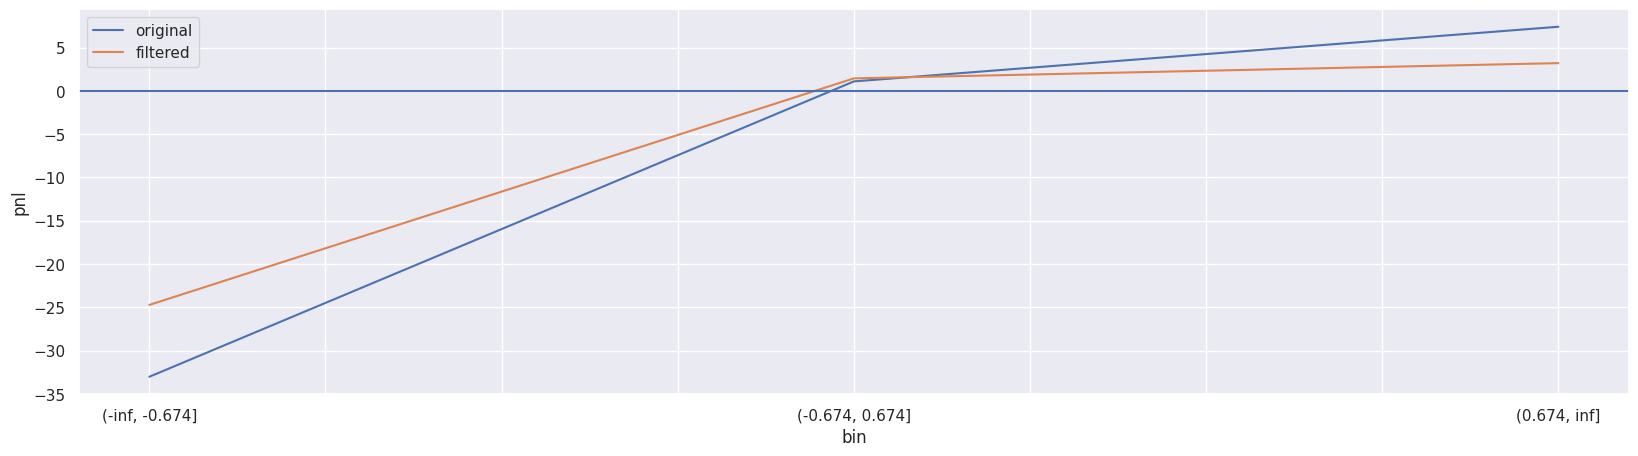

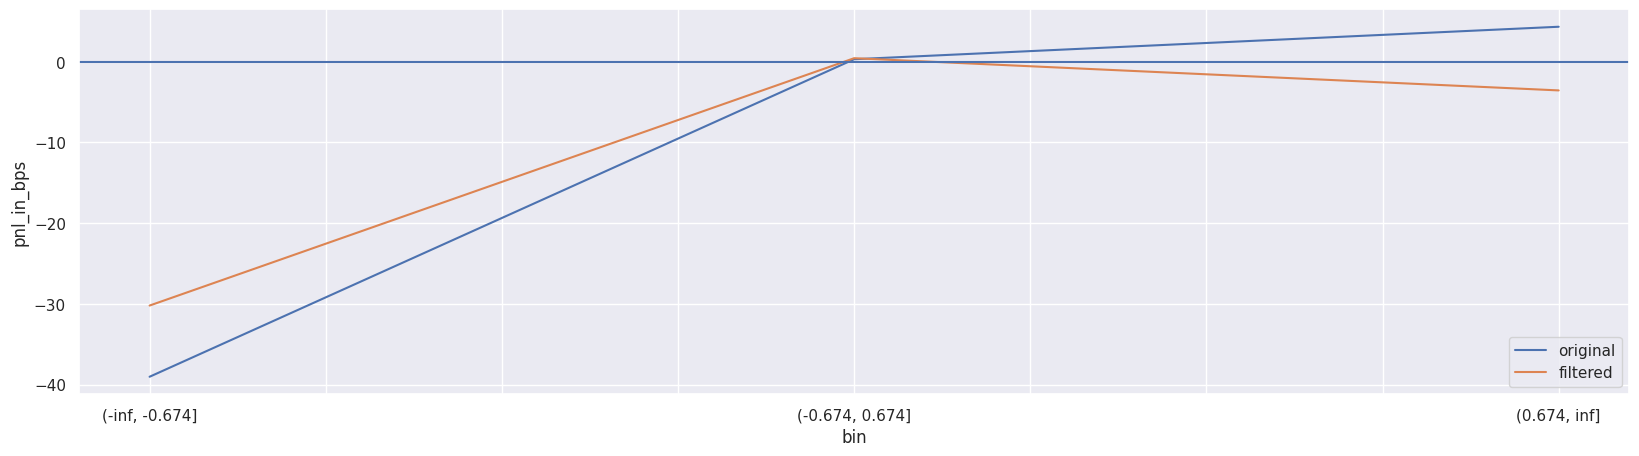

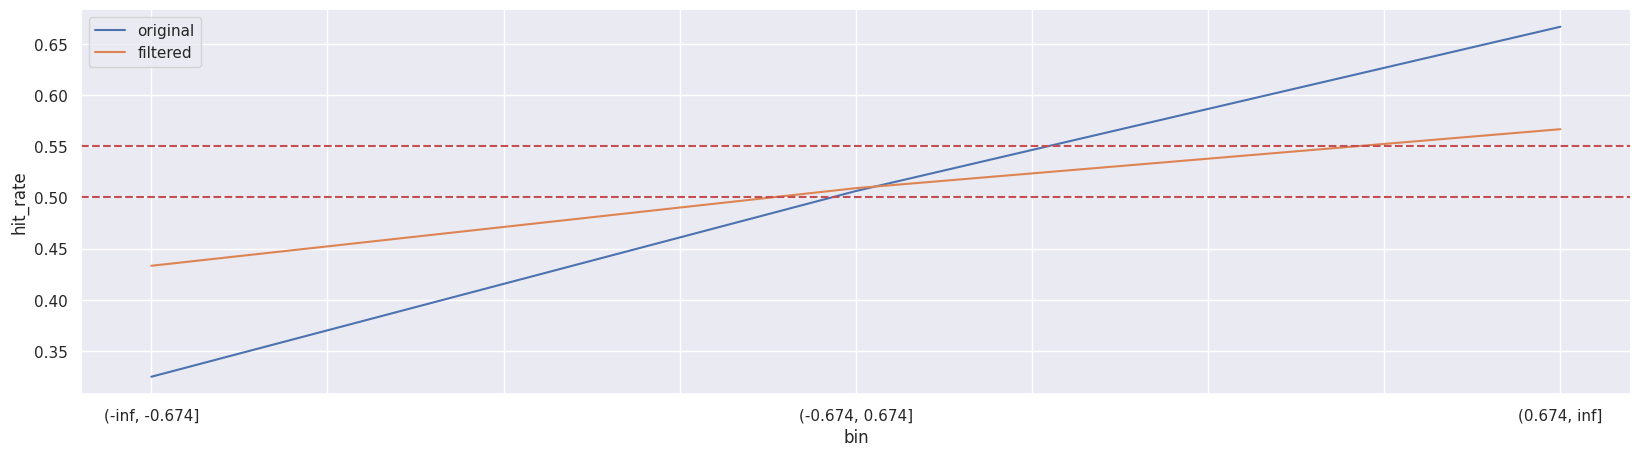

In [102]:
for metric in metric_modes:
    metric_stats = fep.bin_annotated_portfolio_df(
        portfolio_df,
        config["fep_binning_portfolio"]["proportion_of_data_per_bin"],
        metric,
    )["mean"].mean(axis=1)
    metric_stats_filtered = fep.bin_annotated_portfolio_df(
        portfolio_df_filtered,
        config["fep_binning_portfolio"]["proportion_of_data_per_bin"],
        metric,
    )["mean"].mean(axis=1)
    all_metric_stats = pd.concat(
        [metric_stats, metric_stats_filtered],
        axis=1,
        keys=["original", "filtered"],
    )
    # Plot.
    _ = all_metric_stats.plot(
        kind="line",
        ylabel=metric,
        xlabel="bin",
        rot=0,
    )
    if metric == "hit_rate":
        plt.axhline(y=0.5, color="r", linestyle="--")
        plt.axhline(y=0.55, color="r", linestyle="--")
    else:
        plt.axhline(y=0.0, color="b", linestyle="-")
    plt.show()